<a href="https://colab.research.google.com/github/lisosoma/BI_NGS/blob/main/NGS_HW7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install conda and add channels to look for packages in
import sys
! wget https://repo.anaconda.com/archive/Anaconda3-2020.02-Linux-x86_64.sh
! chmod +x Anaconda3-2020.02-Linux-x86_64.sh
! bash ./Anaconda3-2020.02-Linux-x86_64.sh -b -f -p /usr/local
sys.path.append('/usr/local/lib/python3.7/site-packages/')
! conda update -n base -c defaults conda -y
! conda config --add channels bioconda
! conda config --add channels conda-forge

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**1. Выравнивание ридов RNA-Seq**

Приложить риды RNA-Seq на геном (можно с использованием базы генов) с помощью программ HISAT2 или STAR (на выбор).


Установим HISAT2 для выравнивания РНК-ридов.

In [ ]:
!conda install -c bioconda hisat2

In [ ]:
!gunzip /content/drive/MyDrive/hw7/ref.fa.gz

In [ ]:
!hisat2-build /content/drive/MyDrive/hw7/ref.fa genome_index.ht2

In [ ]:
!conda install -c bioconda samtools

In [62]:
!gunzip /content/drive/MyDrive/hw7/SRR453566_1.fastq.gz

In [63]:
!gunzip /content/drive/MyDrive/hw7/SRR453566_2.fastq.gz

Выровняем риды.

In [9]:
!hisat2 -x genome_index.ht2 -1 /content/drive/MyDrive/hw7/SRR453566_1.fastq -2 /content/drive/MyDrive/hw7/SRR453566_2.fastq -S out.sam 

5725730 reads; of these:
  5725730 (100.00%) were paired; of these:
    1190825 (20.80%) aligned concordantly 0 times
    4291355 (74.95%) aligned concordantly exactly 1 time
    243550 (4.25%) aligned concordantly >1 times
    ----
    1190825 pairs aligned concordantly 0 times; of these:
      136484 (11.46%) aligned discordantly 1 time
    ----
    1054341 pairs aligned 0 times concordantly or discordantly; of these:
      2108682 mates make up the pairs; of these:
        1419213 (67.30%) aligned 0 times
        637765 (30.24%) aligned exactly 1 time
        51704 (2.45%) aligned >1 times
87.61% overall alignment rate


**2. Оценка количества экспрессирующихся генов**

По полученному SAM файлу и базе генов оценить процент экспрессирующихся генов. Какая часть гена должна быть покрыта и какая глубина должна быть чтобы он считался таковым, решите сами. Можно взять, к примеру, 95%. Глубину (экспрессию) лучше всего мерять в величинах FPKM или TPM.


In [17]:
!samtools view -S -b  out.sam > out.bam

In [18]:
!cp out.bam "drive/My Drive/hw7"

In [ ]:
!head -20 out.sam

In [ ]:
!head -20 /content/drive/MyDrive/hw7/genes.gtf

In [ ]:
!conda install bcbio-gff

In [ ]:
!pip install pyfaidx

In [ ]:
import gffutils

In [ ]:
def coverage_fix(sam, fasta):
    align = ps.AlignmentFile(sam, 'rb')
    reference = SeqIO.read(fasta, 'fasta').seq
    cov = np.zeros(len(reference))
    
    for read in tqdm(align.fetch()):
        start, end = read.reference_start, read.reference_end
        if start and end:
            cov[start:end] += 1
            
    return cov

In [83]:
!wget https://github.com/deweylab/RSEM/archive/v1.3.3.tar.gz

--2022-04-28 18:38:40--  https://github.com/deweylab/RSEM/archive/v1.3.3.tar.gz
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/deweylab/RSEM/tar.gz/refs/tags/v1.3.3 [following]
--2022-04-28 18:38:41--  https://codeload.github.com/deweylab/RSEM/tar.gz/refs/tags/v1.3.3
Resolving codeload.github.com (codeload.github.com)... 140.82.113.9
Connecting to codeload.github.com (codeload.github.com)|140.82.113.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘v1.3.3.tar.gz’

v1.3.3.tar.gz           [       <=>          ]   9.10M  6.18MB/s    in 1.5s    

2022-04-28 18:38:42 (6.18 MB/s) - ‘v1.3.3.tar.gz’ saved [9540102]



In [84]:
!gunzip /content/v1.3.3.tar.gz

gzip: /content/v1.3.3.tar already exists; do you wish to overwrite (y or n)? y


In [95]:
!cd /content/RSEM-1.3.3

In [ ]:
!make install

In [ ]:
!conda install -c bioconda bowtie2

In [ ]:
!/content/RSEM-1.3.3/rsem-calculate-expression --paired-end --alignments -p 8 out.sam /content/drive/MyDrive/hw7/ref.fa mmliver_paired_end_quals

In [113]:
!cd /content/RSEM-1.3.3

In [115]:
!cd /content/RSEM-1.3.3/EBSeq

In [ ]:
!make install

In [ ]:
!rsem-sam-validator /content/out.sam

In [ ]:
!wget https://sourceforge.net/projects/subread/files/subread-2.0.3/subread-2.0.3-Linux-x86_64.tar.gz

In [66]:
!gunzip subread-2.0.3-Linux-x86_64.tar.gz

In [ ]:
!tar  -xvf subread-2.0.3-Linux-x86_64.tar

In [72]:
!/content/subread-2.0.3-Linux-x86_64/bin/featureCounts -g gene_id -a /content/drive/MyDrive/hw7/genes.gtf -o counts.txt -p --countReadPairs *.sam 


        ==========     _____ _    _ ____  _____  ______          _____  
        =====         / ____| |  | |  _ \|  __ \|  ____|   /\   |  __ \ 
          =====      | (___ | |  | | |_) | |__) | |__     /  \  | |  | |
            ====      \___ \| |  | |  _ <|  _  /|  __|   / /\ \ | |  | |
              ====    ____) | |__| | |_) | | \ \| |____ / ____ \| |__| |
        ==========   |_____/ \____/|____/|_|  \_\______/_/    \_\_____/
	  v2.0.3

//========================== featureCounts setting ===========================\\
||                                                                            ||
||             Input files : 1 SAM file                                       ||
||                                                                            ||
||                           out.sam                                          ||
||                                                                            ||
||             Output file : counts.txt                          

In [73]:
!cat counts.txt.summary

Status	out.sam
Assigned	4647213
Unassigned_Unmapped	400120
Unassigned_Read_Type	0
Unassigned_Singleton	0
Unassigned_MappingQuality	0
Unassigned_Chimera	0
Unassigned_FragmentLength	0
Unassigned_Duplicate	0
Unassigned_MultiMapping	860762
Unassigned_Secondary	0
Unassigned_NonSplit	0
Unassigned_NoFeatures	132432
Unassigned_Overlapping_Length	0
Unassigned_Ambiguity	256267


In [134]:
!conda install -c bioconda rsem

Solving environment: | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | 

In [1]:
!head out.bam

head: cannot open 'out.bam' for reading: No such file or directory


**3. Сборка de novo**

Соберите риды с нуля любым RNA-Seq сборщиком (например Trinity или rnaSPAdes), запустите на полученных контигах rnaQUAST или самостоятельно оцените количество собранных генов. Сравните количество покрытых генов с результатом, полученным в пункте 2.


In [ ]:
!conda install -c bioconda spades

In [ ]:
!spades.py --rna \
          -t 16 \
          -m 32 \
          -1 /content/drive/MyDrive/hw7/SRR453566_1.fastq -2 /content/drive/MyDrive/hw7/SRR453566_2.fastq \
          -o rna_assembly

In [ ]:
import shutil
shutil.make_archive('datarna', 'zip', '/content/rna_assembly')
!cp datarna.zip "drive/My Drive/hw7"

In [ ]:
!unzip /content/drive/MyDrive/hw7/datarna.zip -d datarna

In [ ]:
!wget https://github.com/ablab/rnaquast/releases/download/v.2.2.2/rnaQUAST-2.2.2.tar.gz

In [6]:
!gunzip rnaQUAST-2.2.2.tar.gz

In [ ]:
!tar -xvf rnaQUAST-2.2.2.tar

In [ ]:
!pip install gffutils

In [ ]:
!wget https://launchpad.net/ubuntu/+archive/primary/+sourcefiles/gmap/2015-12-31.v7-1/gmap_2015-12-31.v7.orig.tar.gz

In [ ]:
!gunzip /content/gmap_2015-12-31.v7.orig.tar.gz
!tar -xvf /content/gmap_2015-12-31.v7.orig.tar
!cd /content/rnaQUAST-2.2.2/gmap-2015-12-31/

In [ ]:
!python rnaQUAST-2.2.2/rnaQUAST.py \
--transcripts /content/datarna/transcripts.fasta \
--reference /content/drive/MyDrive/hw7/ref.fa --gtf /content/drive/MyDrive/hw7/genes.gtf

In [58]:
!cat /content/rnaQUAST-2.2.2/rnaQUAST_results/results_2022_04_28_17_27_28/short_report.txt

SHORT SUMMARY REPORT 

METRICS/TRANSCRIPTS                                    transcripts              

 == DATABASE METRICS == 
Genes                                                  7126                     
Avg. number of exons per isoform                       1.06

 == BASIC TRANSCRIPTS METRICS == 
Transcripts                                            6512                     
Transcripts > 500 bp                                   4448                     
Transcripts > 1000 bp                                  3641

 == ALIGNMENT METRICS == 
Aligned                                                5931                     
Uniquely aligned                                       5749                     
Multiply aligned                                       53                       
Unaligned                                              581

 == ALIGNMENT METRICS FOR NON-MISASSEMBLED TRANSCRIPTS == 
Avg. aligned fraction                                  0.988                    
Av

In [42]:
from IPython.display import Image

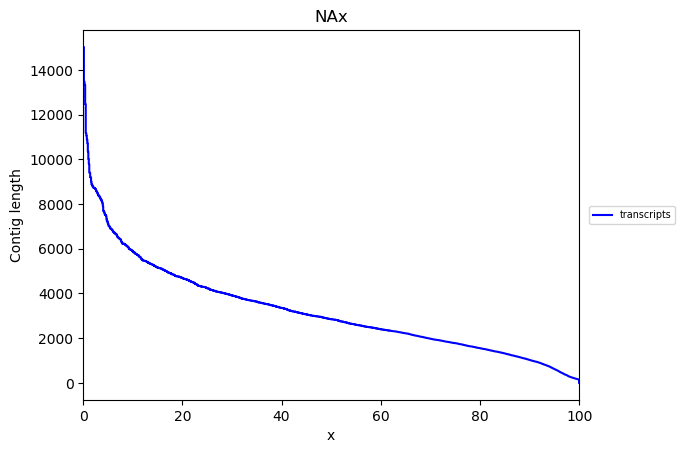

In [44]:
Image("/content/rnaQUAST-2.2.2/rnaQUAST_results/results_2022_04_28_17_27_28/transcripts_output/NAx.png")

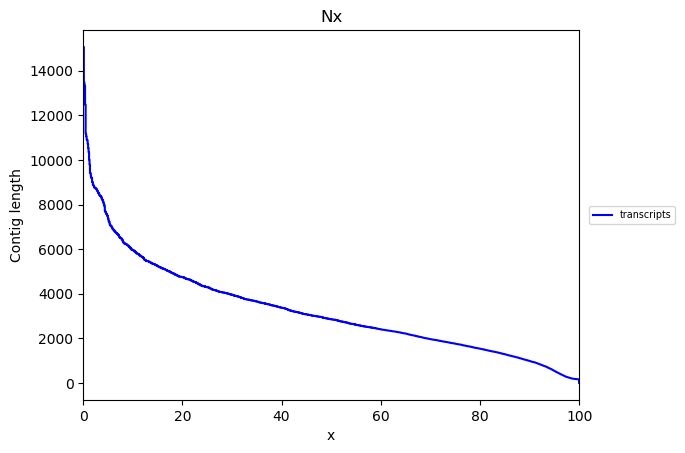

In [45]:
Image("/content/rnaQUAST-2.2.2/rnaQUAST_results/results_2022_04_28_17_27_28/transcripts_output/Nx.png")

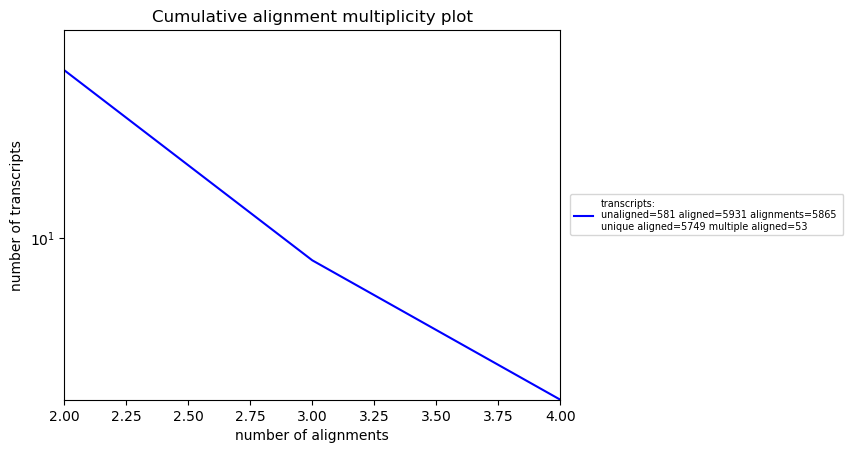

In [46]:
Image("/content/rnaQUAST-2.2.2/rnaQUAST_results/results_2022_04_28_17_27_28/transcripts_output/alignment_multiplicity.png")

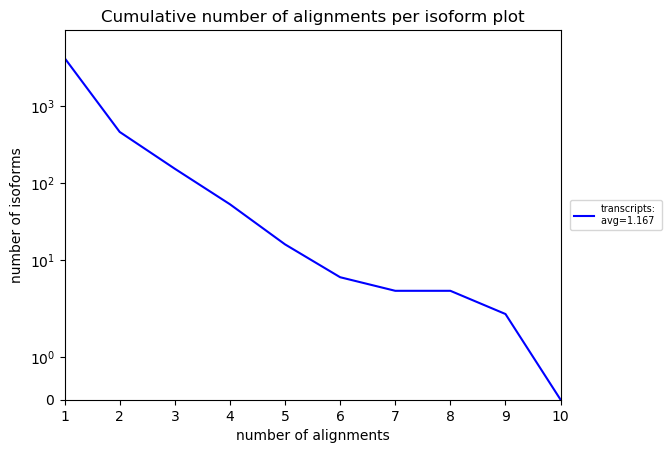

In [47]:
Image("/content/rnaQUAST-2.2.2/rnaQUAST_results/results_2022_04_28_17_27_28/transcripts_output/alignments_per_isoform.png")

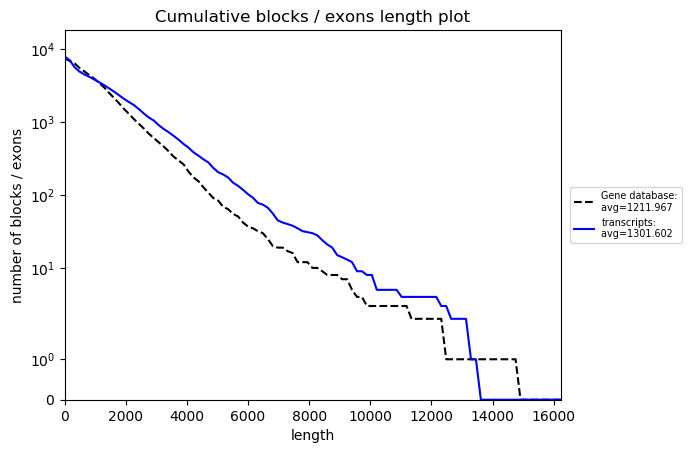

In [48]:
Image("/content/rnaQUAST-2.2.2/rnaQUAST_results/results_2022_04_28_17_27_28/transcripts_output/block_length.png")

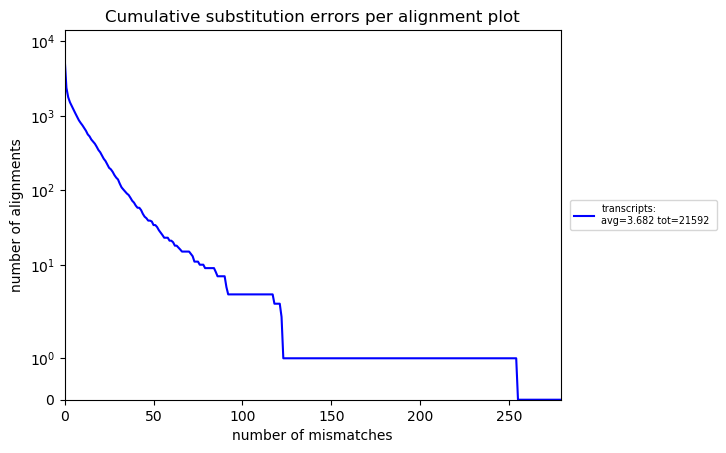

In [49]:
Image("/content/rnaQUAST-2.2.2/rnaQUAST_results/results_2022_04_28_17_27_28/transcripts_output/mismatch_rate.png")

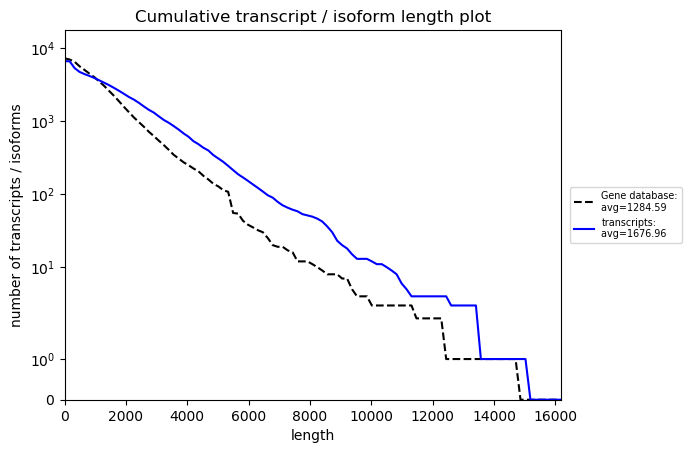

In [50]:
Image("/content/rnaQUAST-2.2.2/rnaQUAST_results/results_2022_04_28_17_27_28/transcripts_output/transcript_length.png")

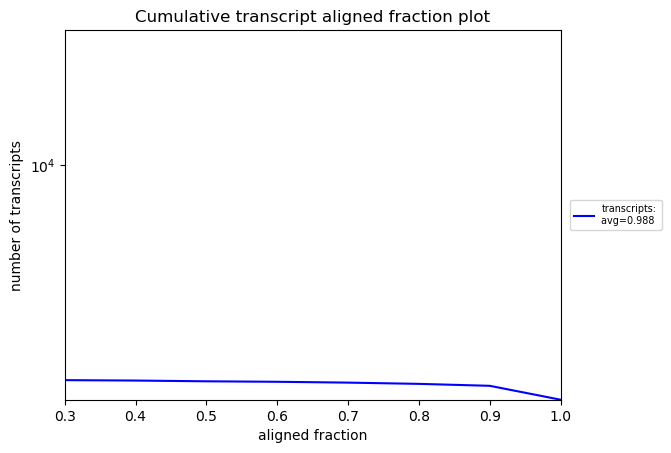

In [51]:
Image("/content/rnaQUAST-2.2.2/rnaQUAST_results/results_2022_04_28_17_27_28/transcripts_output/x-aligned.png")

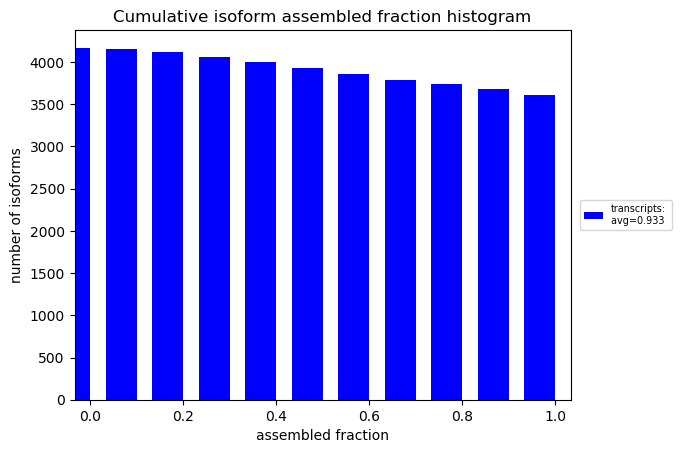

In [52]:
Image("/content/rnaQUAST-2.2.2/rnaQUAST_results/results_2022_04_28_17_27_28/transcripts_output/x-assembled.png")

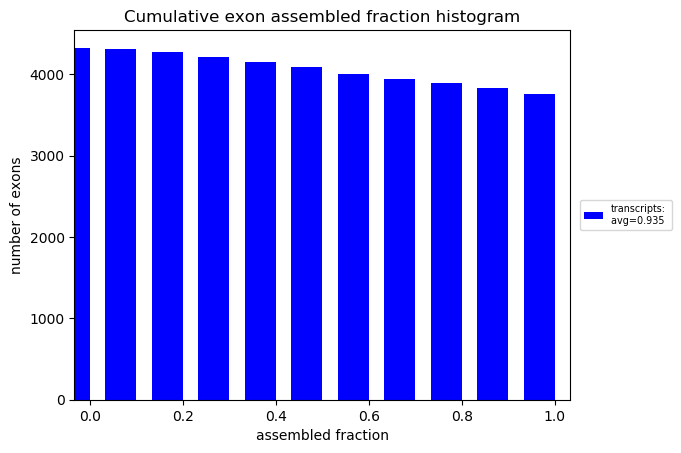

In [53]:
Image("/content/rnaQUAST-2.2.2/rnaQUAST_results/results_2022_04_28_17_27_28/transcripts_output/x-assembled_exons.png")

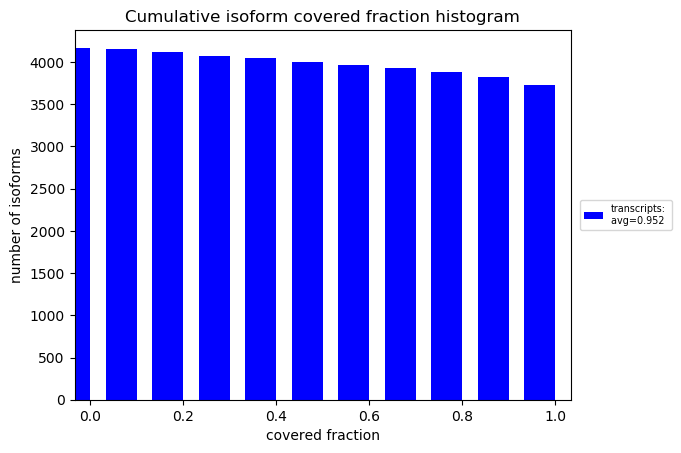

In [54]:
Image("/content/rnaQUAST-2.2.2/rnaQUAST_results/results_2022_04_28_17_27_28/transcripts_output/x-covered.png")

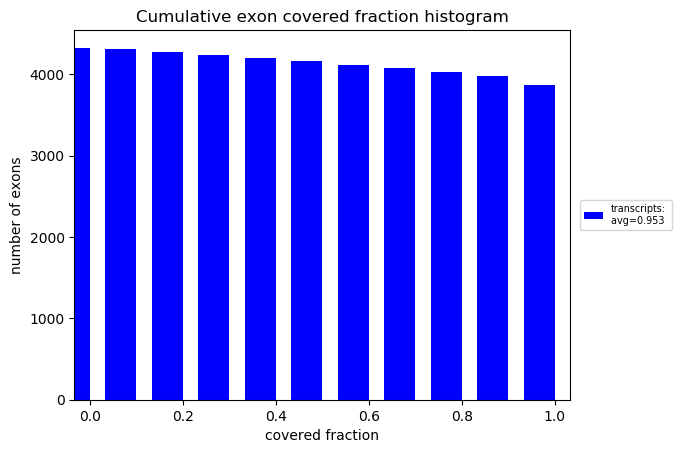

In [55]:
Image("/content/rnaQUAST-2.2.2/rnaQUAST_results/results_2022_04_28_17_27_28/transcripts_output/x-covered_exons.png")

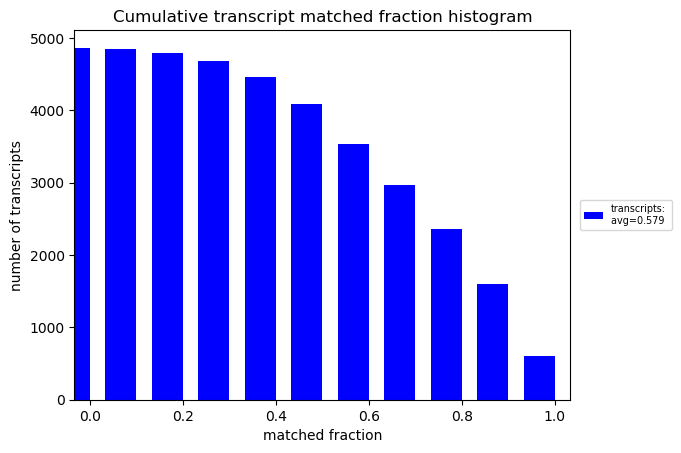

In [56]:
Image("/content/rnaQUAST-2.2.2/rnaQUAST_results/results_2022_04_28_17_27_28/transcripts_output/x-matched.png")

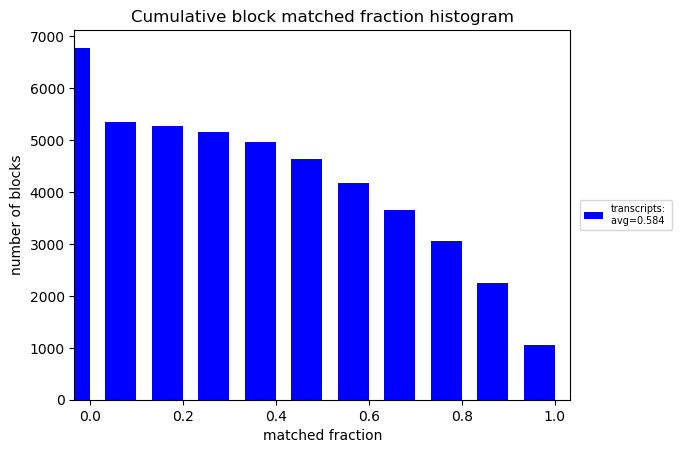

In [57]:
Image("/content/rnaQUAST-2.2.2/rnaQUAST_results/results_2022_04_28_17_27_28/transcripts_output/x-matched_blocks.png")

In [39]:
import shutil
shutil.make_archive('rnaquast', 'zip', '/content/rnaQUAST-2.2.2/rnaQUAST_results/results_2022_04_28_17_27_28')
!cp rnaquast.zip "drive/My Drive/hw7"

In [40]:
!cp /content/rnaQUAST-2.2.2/rnaQUAST_results/results_2022_04_28_17_27_28/short_report.txt "drive/My Drive/hw7"